In [31]:
import surprise
import time
import operator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from wordcloud import WordCloud

%matplotlib inline

In [2]:
movies = pd.read_csv('movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
ratings = pd.read_csv('ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [39]:
ratings.to_csv('ratings_surprise.csv', index=False, header=False)

In [4]:
links = pd.read_csv('links.csv')
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [5]:
tags = pd.read_csv('tags.csv')
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [6]:
movies.info() # null 값은 없음(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [7]:
ratings.info() # null 값은 없음(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [8]:
# Convert genres to one hot encoding
df = pd.merge(movies, ratings)
mdf = pd.concat([df.drop('genres', axis=1), df.genres.str.get_dummies(sep='|')], axis=1)
mdf.head()

,movieId,title,userId,rating,timestamp,(no genres listed),Action,Adventure,Animation,Children,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),1,4.0,964982703,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,Toy Story (1995),5,4.0,847434962,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,Toy Story (1995),7,4.5,1106635946,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,Toy Story (1995),15,2.5,1510577970,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,1,Toy Story (1995),17,4.5,1305696483,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# Get unique genres as
genres_unique = pd.DataFrame(movies.genres.str.split('|').tolist()).stack().unique()
genres_unique = pd.DataFrame(genres_unique, columns=['genres'])
genres_unique.head()

,genres
0,Adventure
1,Animation
2,Children
3,Comedy
4,Fantasy


In [11]:
# Top most rated movies(2)
common = df.groupby('title').size().sort_values(ascending=False)[:10]
common

title
Forrest Gump (1994)                          329
Shawshank Redemption, The (1994)             317
Pulp Fiction (1994)                          307
Silence of the Lambs, The (1991)             279
Matrix, The (1999)                           278
Star Wars: Episode IV - A New Hope (1977)    251
Jurassic Park (1993)                         238
Braveheart (1995)                            237
Terminator 2: Judgment Day (1991)            224
Schindler's List (1993)                      220
dtype: int64

In [16]:
# Number of ratings per genre(3)
unique_genre_dict = {}
for index, row in movies.iterrows():
    genre_combination = row['genres']
    parsed_genre = genre_combination.split('|')
    
    for genre in parsed_genre:
        if genre in unique_genre_dict:
            unique_genre_dict[genre] += 1
        else:
            unique_genre_dict[genre] = 1

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


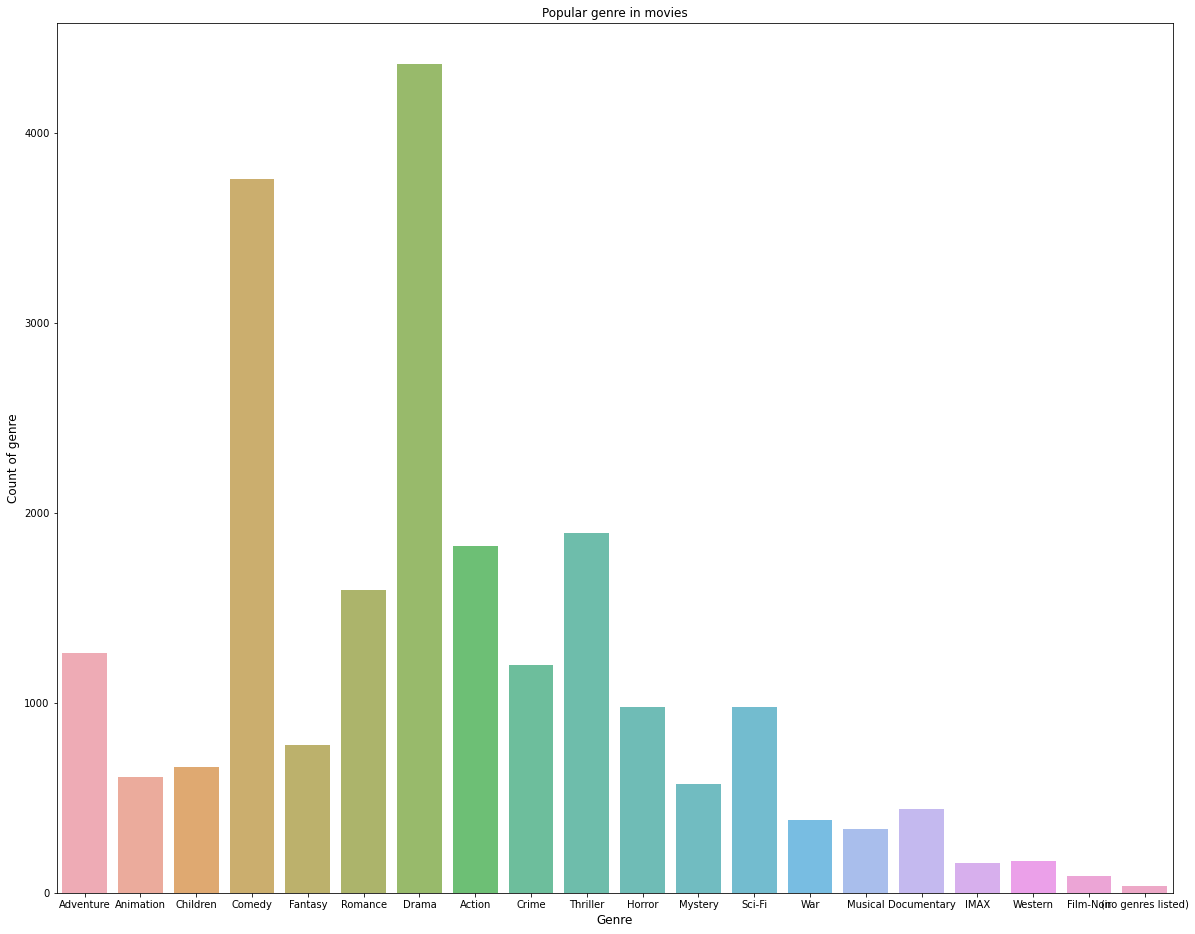

In [17]:
plt.rcParams['figure.figsize'] = [20,16]
sns.barplot(list(unique_genre_dict.keys()), list(unique_genre_dict.values()),
           alpha=0.8)
plt.title('Popular genre in movies')
plt.ylabel('Count of genre', fontsize=12)
plt.xlabel('Genre', fontsize=12)
plt.show()

* Drama, Comdey 순으로 가장 많음을 알 수 있음.

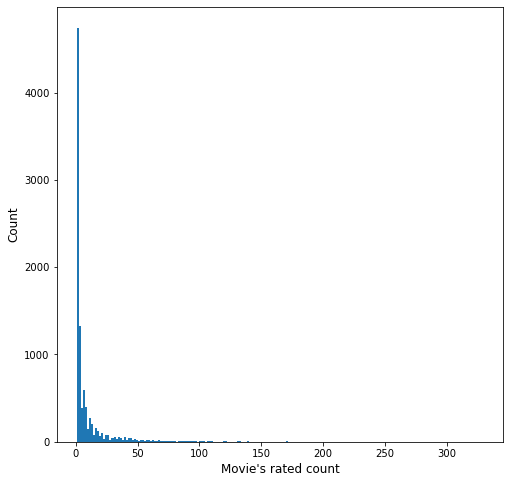

In [19]:
# Exploring information in rating data(4)
movie_rate_count = ratings.groupby('movieId')['rating'].count().values
plt.rcParams['figure.figsize'] = [8,8]
fig = plt.hist(movie_rate_count, bins=200)
plt.ylabel('Count', fontsize=12)
plt.xlabel("Movie's rated count", fontsize=12)
plt.show()

In [20]:
print('Total Number of Movie in data : ', len(movies['movieId'].unique()))
print('Total Number of movie rated below 100 : ', len(movie_rate_count[movie_rate_count<100]))

Total Number of Movie in data :  9742
Total Number of movie rated below 100 :  9586


In [21]:
# Average rating for each movie(5)
movie_grouped_rating_info = ratings.groupby('movieId')['rating'].agg(['count', 'mean'])
movie_grouped_rating_info.columns = ['rated_count', 'rating_mean']

In [22]:
movie_grouped_rating_info.head()

,rated_count,rating_mean
movieId,,
1,215,3.920930
2,110,3.431818
3,52,3.259615
4,7,2.357143
5,49,3.071429


In [26]:
print('평점의 평균 : ', ratings['rating'].mean())
print('평점의 표준편차 : ', ratings['rating'].std())

평점의 평균 :  3.501556983616962
평점의 표준편차 :  1.0425292390605359


<AxesSubplot:>

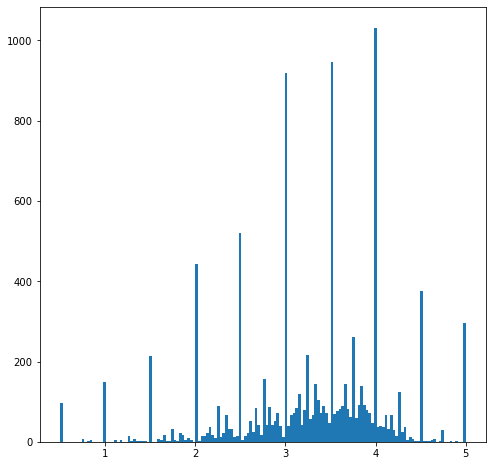

In [23]:
movie_grouped_rating_info['rating_mean'].hist(bins=150, grid=False)

* 대부분의 평점은 2점 ~ 4점 사이로 나타났으며, 대부분 영화 평점이 2점 ~ 4점 사이의 값으로 예측될 것이라는 가설을 수립할 수 있음.

In [28]:
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split

In [34]:
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(ratings[['userId','movieId','rating']], reader)
train_data = data.build_full_trainset()
train, test = train_test_split(data, test_size=0.25, random_state=0)

In [32]:
train_start = time.time()
model = SVD(n_factors=8, lr_all=0.005, reg_all=0.02, n_epochs=100)
model.fit(train_data)
train_end = time.time()
print("training time of model: %.2f seconds" % (train_end - train_start))

training time of model: 14.62 seconds


In [37]:
prediction = model.test(test)
print('Prediction Type : ', type(prediction))
print()
print('Prediction 결과값 5개 미리보기')
print(prediction[:5])
accuracy.rmse(prediction)

Prediction Type :  <class 'list'>

Prediction 결과값 5개 미리보기
[Prediction(uid=63, iid=2000, r_ui=3.0, est=3.765757774357184, details={'was_impossible': False}), Prediction(uid=31, iid=788, r_ui=2.0, est=2.9836488239843364, details={'was_impossible': False}), Prediction(uid=159, iid=6373, r_ui=4.0, est=3.042037376899026, details={'was_impossible': False}), Prediction(uid=105, iid=81564, r_ui=3.0, est=3.965866246408583, details={'was_impossible': False}), Prediction(uid=394, iid=480, r_ui=3.0, est=3.0727370491465402, details={'was_impossible': False})]
RMSE: 0.5856


0.5856138445856669

In [38]:
from surprise.dataset import DatasetAutoFolds
from surprise.dataset import Reader
from surprise import SVD

In [42]:
reader = Reader(line_format='user item rating timestamp', sep=',', rating_scale=(0.5,5))

data_folds = DatasetAutoFolds(ratings_file='ratings_surprise.csv', reader=reader)

trainset = data_folds.build_full_trainset()
algo = SVD(n_factors=50, n_epochs=20, random_state=0)
algo.fit(trainset)

movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

# 특정 사용자 9번의 movieID를 추출해서 특정 영화에 대한 평점이 있는지 확인
movieIds = ratings[ratings['userId'] == 9]['movieId']
if movieIds[movieIds == 42].count() == 0:
    print('user id=9인 사람은 movie id=42에 대한 평점이 없음')

# 영화에 대한 정보 데이터에서 movieId가 42인 영화가 무엇인지 출력
print(movies[movies['movieId'] == 42])

def get_unseen_surprise(ratings, movies, userId):
    seen_movies = ratings[ratings['userId'] == userId]['movieId'].tolist()
    total_movies = movies['movieId'].tolist()
    unseen_movies = [movie for movie in total_movies if movie not in seen_movies]
    print(f'특정 {userId}번 유저가 본 영화 수: {len(seen_movies)}\n추천한 영화 개수: {len(unseen_movies)}\n전체 영화수: {len(total_movies)}')
    
    return unseen_movies

def recomm_movie_by_surprise(algo, userId, unseen_movies, top_n=10):
    predictions = [algo.predict(str(userId), str(movieId)) for movieId in unseen_movies]
    
    def sortkey_est(pred):
        return pred.est
    
    predictions.sort(key=sortkey_est, reverse=True)
    
    top_predictions = predictions[:top_n]
    
    top_movie_ids = [int(pred.iid) for pred in top_predictions]
    top_movie_ratings = [pred.est for pred in top_predictions]
    top_movie_titles = movies[movies.movieId.isin(top_movie_ids)]['title']
    top_movie_preds = [(ids, rating, title) for ids, rating, title in zip(top_movie_ids, top_movie_ratings, top_movie_titles)]
    
    return top_movie_preds

unseen_lst = get_unseen_surprise(ratings, movies, 9)
top_movies_preds = recomm_movie_by_surprise(algo, 9, unseen_lst, top_n=10)

print()
print('#'*8,'Top-10 추천영화 리스트','#'*8)

for top_movie in top_movies_preds:
    print('* 추천 영화 이름: ', top_movie[2])
    print('* 해당 영화의 예측평점: ', top_movie[1])
    print()

user id=9인 사람은 movie id=42에 대한 평점이 없음
    movieId                   title              genres
38       42  Dead Presidents (1995)  Action|Crime|Drama
특정 9번 유저가 본 영화 수: 46
추천한 영화 개수: 9696
전체 영화수: 9742

######## Top-10 추천영화 리스트 ########
* 추천 영화 이름:  Usual Suspects, The (1995)
* 해당 영화의 예측평점:  4.306302135700814

* 추천 영화 이름:  Star Wars: Episode IV - A New Hope (1977)
* 해당 영화의 예측평점:  4.281663842987387

* 추천 영화 이름:  Pulp Fiction (1994)
* 해당 영화의 예측평점:  4.278152632122759

* 추천 영화 이름:  Silence of the Lambs, The (1991)
* 해당 영화의 예측평점:  4.226073566460876

* 추천 영화 이름:  Godfather, The (1972)
* 해당 영화의 예측평점:  4.1918097904381995

* 추천 영화 이름:  Streetcar Named Desire, A (1951)
* 해당 영화의 예측평점:  4.154746591122658

* 추천 영화 이름:  Star Wars: Episode V - The Empire Strikes Back (1980)
* 해당 영화의 예측평점:  4.122016128534504

* 추천 영화 이름:  Star Wars: Episode VI - Return of the Jedi (1983)
* 해당 영화의 예측평점:  4.108009609093436

* 추천 영화 이름:  Goodfellas (1990)
* 해당 영화의 예측평점:  4.083464936588478

* 추천 영화 이름:  Glory (1989)
* 해당 영화